In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer   
import textwrap
import seaborn as sns
import preamble
import torch
import src.constants as const

In [2]:
MODEL_NAME = "google/embeddinggemma-300m" # previously chosen embedding model
OUTDATED_MODELS = ["jinaai/jina-embeddings-v3",
            "jinaai/jina-embeddings-v4",
            "Snowflake/snowflake-arctic-embed-l-v2.0",
            "BAAI/bge-m3", 
            'sentence-transformers/all-MiniLM-L6-v2', 
            'sentence-transformers/all-mpnet-base-v2',
            'Qwen/Qwen3-Embedding-0.6B']

In [3]:
# import dataframe of migration speeches with embeddings
df = pd.read_parquet(const.PATH_MIGRATION_SPEECHES_EMBEDDED)

In [4]:
# delete all columns of outdated models to save memory
for outdated_model in OUTDATED_MODELS:
    if outdated_model in df.columns:
        del df[outdated_model]

In [5]:
# inspect the dataframe
df.head()

Unnamed: 0            speaker  \
492          492     Karen Melchior   
844          844       Tineke Strik   
1050        1050  Anabela Rodrigues   
1054        1054        Beata Kempa   
1056        1056   Dorien Rookmaker   

                                                   text        date  \
492   Mr President, thank you very much to the Commi...  2024-04-24   
844   Mr President, Commissioner. People who flee wa...  2024-04-23   
1050  Senhora Presidente, em 2024, o tráfico de sere...  2024-04-22   
1054  Pani Przewodnicząca! Pani Komisarz! Potrzebuje...  2024-04-22   
1056  Voorzitter, dank u wel, meneer Engerer, want u...  2024-04-22   

                                                 agenda  speechnumber  \
492   22. Advance passenger information: enhancing a...             8   
844   17. EU-Egypt strategic and comprehensive partn...             9   
1050  20. Amending Directive 2011/36/EU on preventin...            10   
1054  20. Amending Directive 2011/36/EU on preventin...            14   
1056  20. Amending Directive 2011/36/EU on preventin...            16   

                                           procedure_ID  partyfacts_ID  \
492    bill_26075_ID bill_26076_ID  bill_26075_ID bi...         6401.0   
844                                                             6403.0   
1050                           bill_241_ID  bill_241_ID         6402.0   
1054                           bill_241_ID  bill_241_ID         6400.0   
1056                           bill_241_ID  bill_241_ID         6400.0   

      period  chair  ...  written  multispeaker  \
492        9  False  ...    False         False   
844        9  False  ...    False         False   
1050       9  False  ...    False         False   
1054       9  False  ...    False         False   
1056       9  False  ...    False         False   

                                                   link  \
492   https://www.europarl.europa.eu/doceo/document/...   
844   https://www.europarl.europa.eu/doceo/document/...   
1050  https://www.europarl.europa.eu/doceo/document/...   
1054  https://www.europarl.europa.eu/doceo/document/...   
1056  https://www.europarl.europa.eu/doceo/document/...   

                                         translatedText translationSource  \
492   Mr President, thank you very much to the Commi...       original_gm   
844   Mr President, Commissioner. People who flee wa...       original_gm   
1050  Madam President, in 2024, human trafficking co...        machine_gm   
1054  Madam Commissioner! We need very specific, ver...        machine_gm   
1056  Madam President, thank you, Mr Engerer, becaus...        machine_gm   

      year            block            party migration_prob  \
492   2024          liberal  ELDR/ALDE/Renew       0.393282   
844   2024            green       Greens/EFA       0.423501   
1050  2024             left     NGL/The Left       0.375925   
1054  2024  (extreme)_right              ECR       0.256493   
1056  2024  (extreme)_right              ECR       0.475315   

                             google/embeddinggemma-300m  
492   [-0.06368264, -0.01790871, 0.008169121, 0.0173...  
844   [-0.06358229, 0.05332363, -0.006831329, 0.0041...  
1050  [-0.049918693, -0.001202861, -0.008896867, -0....  
1054  [-0.035047594, 0.03835739, -0.051198084, 0.050...  
1056  [-0.06766452, 0.015919995, -0.019874139, -0.01...  

[5 rows x 22 columns]

In [6]:
# load the google embedding model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu" 
model = SentenceTransformer(MODEL_NAME, trust_remote_code=True).to(device)

In [7]:
# hard-code migration narratives identified in Seiger et al., 2025 (Report from Joint Research Centre of the European Commission)
queries_jrc = {
    "anti_immigration" : 
    ["Immigration is bad",
    "Immigrants’ identity or culture is problematic",
    "Immigration is a threat to the European way of life and identity",
    "Arabs and Muslims are a cultural or social threat",
    "Certain immigrants are unwilling or incapable to integrate",
    "Immigration is a threat to individual safety",
    "Immigration is a threat to national security",
    "Immigrants are prone to committing crimes (violent, non-violent, organised, sexual)",
    "Many immigrants are terrorists",
    "Immigrants spread diseases",
    "There are too many immigrants coming",
    "Immigrants do not contribute to the economy",
    "Immigrants take our jobs",
    "Many asylum seekers are actually economic migrants",
    "Immigrants abuse the welfare system",
    "Immigrants are a strain on our health-care system",
    "Immigrants are a strain on the housing market",
    "Immigration reduces the attractiveness of location and lowers overall life quality",
    "Receiving immigrants is too expensive/ immigration burdens tax payers"
    ],
    "immigrants_are_victims": 
    ["Immigrants are victims of human traffickers",
    "Certain immigrants or asylum seekers are discriminated against",
    "EU is in breach of international law",
    "Immigrants suffer from labour exploitation"
    ],
    "populist/anti-elitist": 
    ["EU is harmful for our nation",
    "Let’s overthrow the establishment",
    "Political rivals act against the interests of the people",
    "Our sovereignty is under threat"
    ]
}
queries_jrc_flat = [query for category_queries in queries_jrc.values() for query in category_queries]  

In [8]:
# embed jrc queries
query_embeddings = model.encode_query(queries_jrc_flat, batch_size=32)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
# compute cosine similarity between query embeddings and speech embeddings for every speech
for i, query_embedding in enumerate(query_embeddings):
    column_name = queries_jrc_flat[i]
    df[column_name] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

In [10]:
def top_speeches(df, query, n=5):
    '''Prints the top n speeches that have the highest cosine similarity to the query'''
    if query not in df.columns:
        print(f"Query '{query}' not found in dataframe columns, computing embedding..." )
        query_embedding = model.encode_query([query], batch_size=1)[0]
        df[query] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])
    top = df.nlargest(n, query)
    print(f"Top {n} speeches for query: '{query}'")
    for _, row in top.iterrows():
        print(f"{row['speaker']}  (sim={row[query]:.4f})")
        print(textwrap.fill(row['translatedText'], width=90))
        print()
    print("--------------------------------------------------\n")

In [ ]:
for query in queries_jrc_flat:
    top_speeches(df, query, n=5)

Top 5 speeches for query: 'Immigration is bad'
Catherine Stihler  (sim=0.5220)
I voted against this report. The language used in the paragraph regarding the
‘uncontrolled influx of immigrants’ is unhelpful in the context of this report and the
wider refugee crisis debate.

Nadine Morano  (sim=0.4929)
I abstained on this report, certain provisions of which clearly constituted a call for
illegal immigration. Indeed, by asking to integrate migrants, who have not even obtained
refugee status and are therefore illegal immigrants, into the various education and
training programs, this text suggests that we can with dignity welcome migrants in Europe,
when in reality we are not able to provide them with housing, employment or the means to
assimilate properly.

Gilles Lebreton  (sim=0.4887)
I voted against this report because it will facilitate immigration, whereas we should
rather dissuade migrants from coming to Europe.

Auke Zijlstra  (sim=0.4852)
There are few good developments in immigrat

In [ ]:
# aggregate over parties and years in case we want to inspect mean similarities
agg = (
    df
    .groupby(["block", "year"])
    .agg({q: "mean" for q in queries_jrc_flat})
    .reset_index()
)

# add number of speeches per group (not currently used, but potentially relevant)
counts = df.groupby(["block", "year"]).size().reset_index(name="n_speeches")
agg = agg.merge(counts, on=["block", "year"])

## Plot cosine similarities for every party over time

In [17]:
def mean_similarity_plots(ax, df, query):
    if query not in df.columns:
        print(f"Query '{query}' not found in dataframe columns, computing embedding..." )
        query_embedding = model.encode_query([query], batch_size=1)[0]
        df[query] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])
    sns.lineplot(data=df, x='year', y=query, hue='block', marker='o', palette=const.COLOR_MAP_BLOCK, ax=ax, errorbar='ci')
    ax.set_title(query[:60] + ("..." if len(query) > 60 else ""))
    ax.set_ylabel("Mean Cosine Similarity")
    ax.set_xlabel("Year")
    # ax.legend(title='Party Block')
    ax.grid(True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

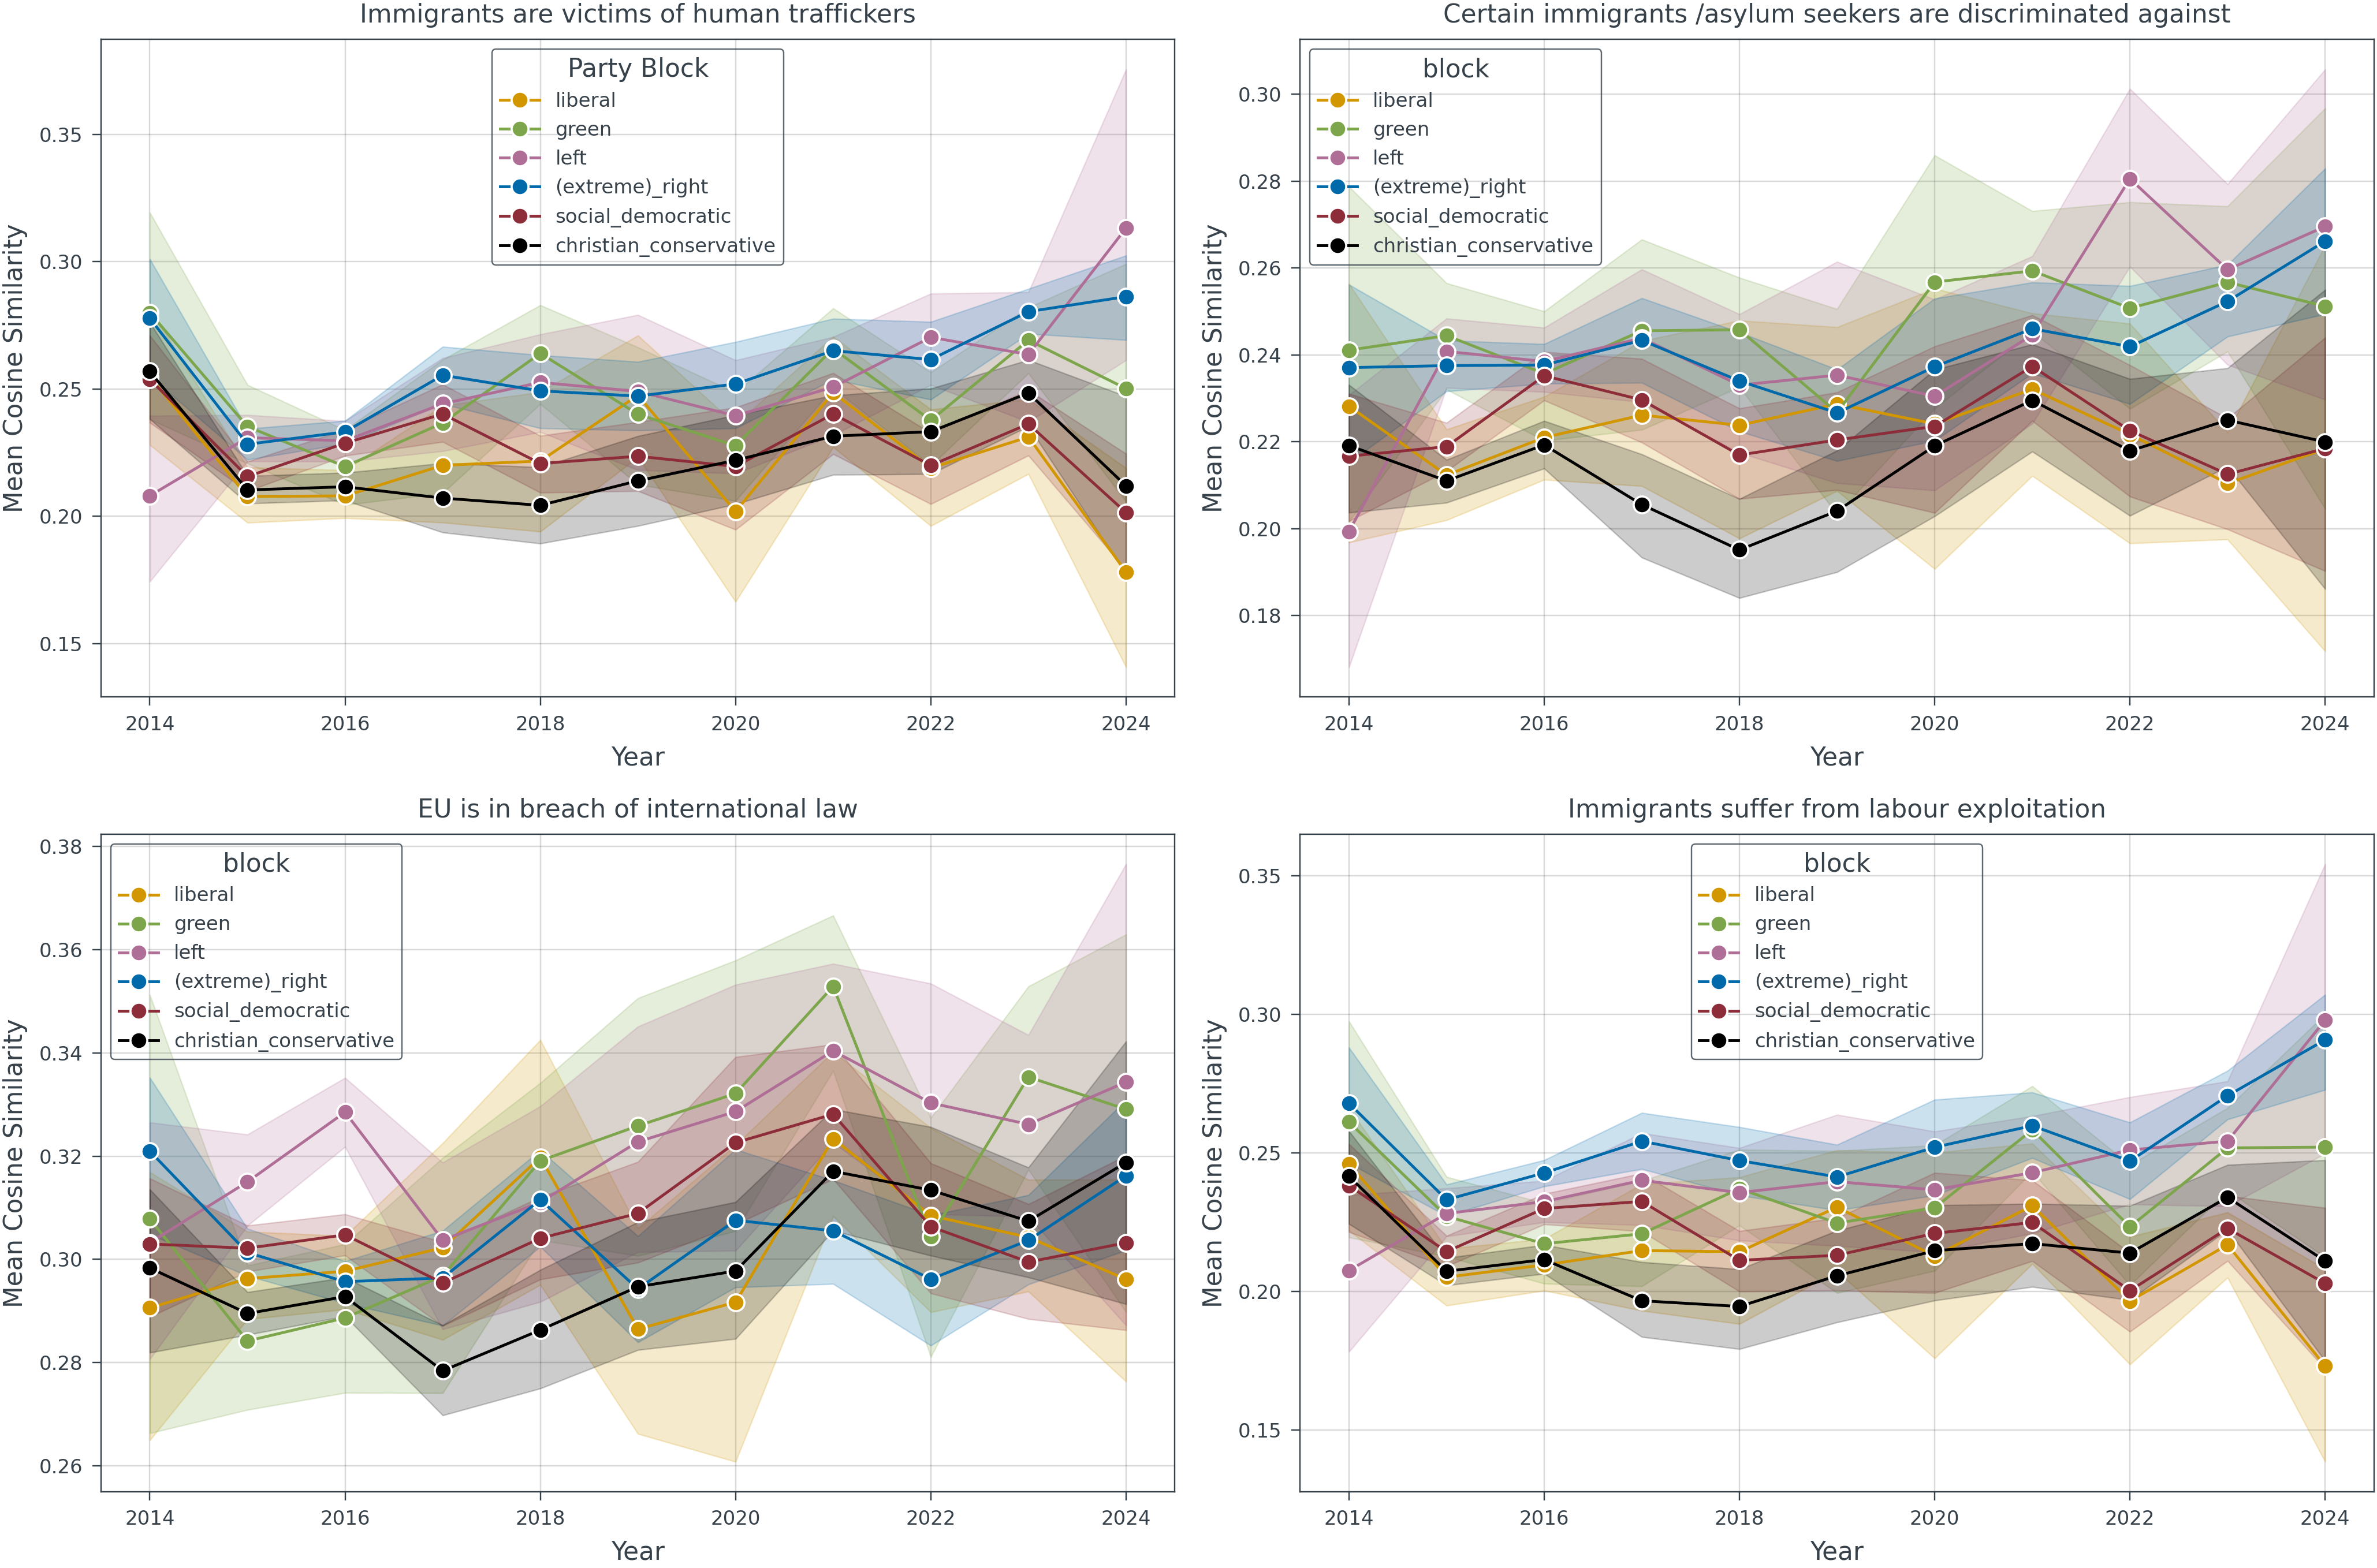

In [ ]:
queries = queries_jrc_flat
fig, axes = plt.subplots(len(queries)//2, 2, figsize=(12, 4 * len(queries)//2))
for ax, query in zip(axes.flatten(), queries):
    mean_similarity_plots(ax, df, query)
    # on first pass, set legend
    if ax == axes.flatten()[0]:
        ax.legend(title='Party Block')

plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

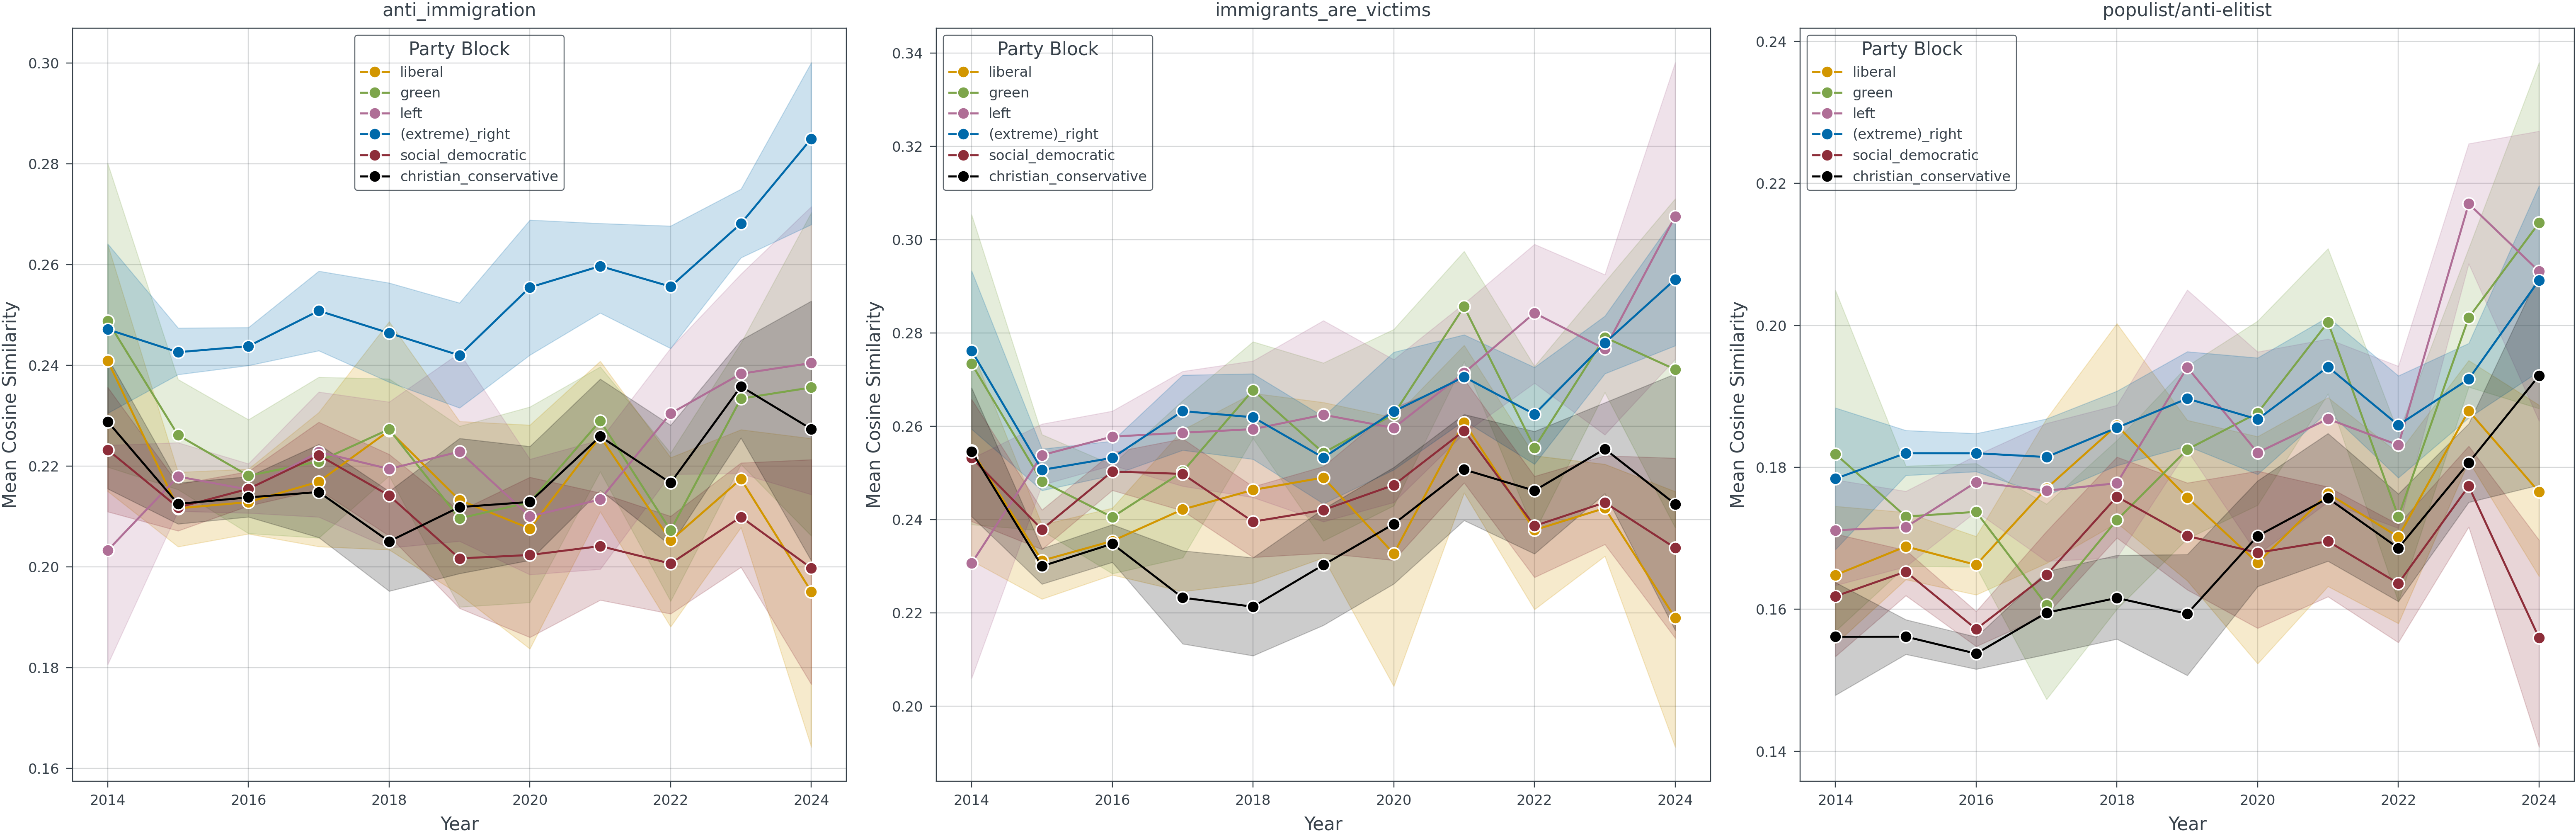

In [20]:
# compute average similarity for each category
for category, category_queries in queries_jrc.items():
    df[category] = df[category_queries].mean(axis=1)

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, category in zip(axes, queries_jrc.keys()):
    mean_similarity_plots(ax, df, category)
    ax.legend(title='Party Block')

plt.tight_layout()
plt.show()